# Trabalho 2 - Store Sales - Time Series Forecasting


*   **Aluno: Lucas Tavares S. Ferreira**
*   **DRE: 120152739**
*   **21/05/2025**



## Results

The set that had the best result using LGBMRegressor was 'sales_holidays' with only the basic information and the holiday. It was tested w/ other models but LGBMRegressor still had the best result.

``Score: 0.7352``

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from prophet import Prophet
from lightgbm import LGBMRegressor

import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

## Reading data

In [2]:
oil = pd.read_csv('oil.csv')
stores = pd.read_csv('stores.csv')
holidays = pd.read_csv('holidays_events.csv')
transactions = pd.read_csv('transactions.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Análise Exploratória

In [3]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [4]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [5]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [7]:
holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [8]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [9]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [10]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [11]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [13]:
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


## Sales correlation

In [15]:
train.corr(numeric_only=True)['sales']

id             0.085784
store_nbr      0.041196
sales          1.000000
onpromotion    0.427923
Name: sales, dtype: float64

### Average sales by day of the week

In [16]:
eda = train.copy()
eda['date'] = pd.to_datetime(eda['date'])

In [17]:
eda['day_of_week'] = eda['date'].dt.day_name()
avg_sales_per_day = eda.groupby('day_of_week')['sales'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

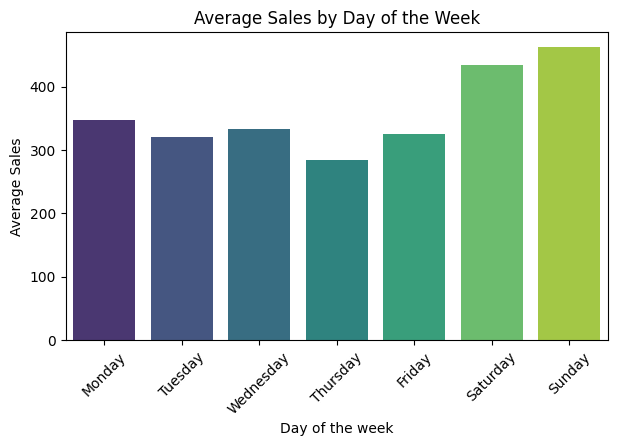

In [18]:
plt.figure(figsize=(7, 4))
sns.barplot(x=avg_sales_per_day.index, hue= avg_sales_per_day.index, y=avg_sales_per_day.values, palette="viridis")
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the week')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.show()

### Average sales per month

In [19]:
eda['month'] = eda['date'].dt.month_name()
avg_sales_per_month = eda.groupby('month')['sales'].mean().reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

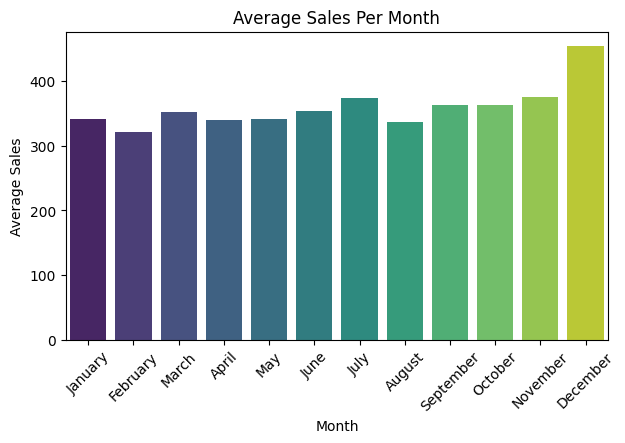

In [20]:
plt.figure(figsize=(7, 4))
sns.barplot(x=avg_sales_per_month.index,  hue= avg_sales_per_month.index, y=avg_sales_per_month.values, palette="viridis")
plt.title('Average Sales Per Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.show()

### Average sales per day of the month

In [21]:
eda['day_of_month'] = eda['date'].dt.day
avg_sales_per_day = eda.groupby('day_of_month')['sales'].mean()

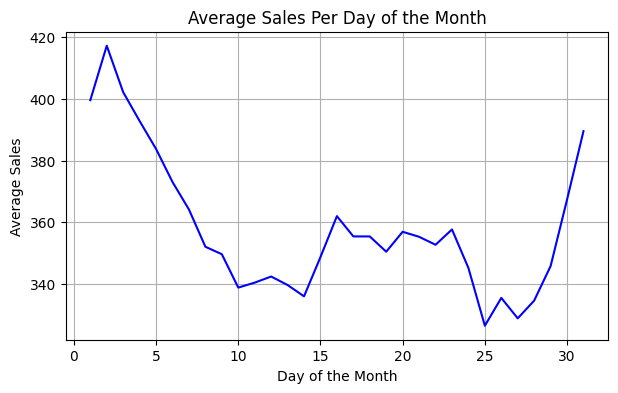

In [22]:
plt.figure(figsize=(7, 4))
sns.lineplot(x=avg_sales_per_day.index, y=avg_sales_per_day.values, color='b')
plt.title('Average Sales Per Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

### Average sales throughout the year

In [23]:
eda['day_of_year'] = eda['date'].dt.dayofyear
avg_sales_per_day_of_year = eda.groupby('day_of_year')['sales'].mean()

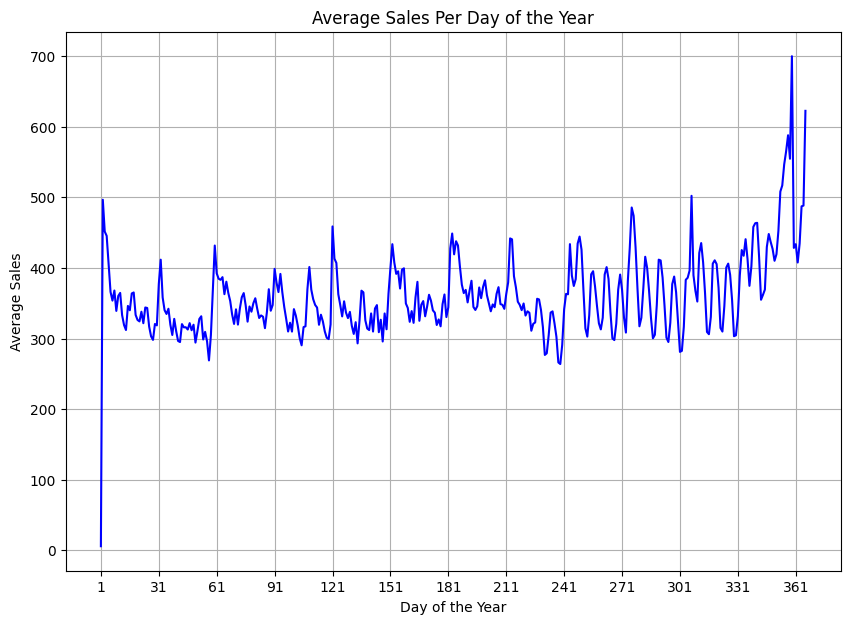

In [24]:
plt.figure(figsize=(10, 7))
sns.lineplot(x=avg_sales_per_day_of_year.index, y=avg_sales_per_day_of_year.values, color='b')
plt.title('Average Sales Per Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Average Sales')
plt.xticks(range(1, 366, 30)) 
plt.grid(True)
plt.show()

### Conclusions about Sales

Week:
- Are bigger on the weekend

Month:
- December is by far the best month for sales.
- In general, sales are biggest at the beginning of the month and then decrease until they increase a little at the end of the month.

Year:
- January 1st seems to have no sales, followed by a spike.
- There are spikes in sales at the beginning of the month in general.
- High number of sales at the end of the year.

---


## Concatenating Train and Test data for transformations

In [25]:
sales_df = pd.concat([train, test], ignore_index=True)
split_index = len(train) 
test_id = test['id']

## 1. Forecast with only store and product information

Results: best RMSLE estimate with only this information -> 0.4583933293248055

In [26]:
sales_df = sales_df.merge(stores, on='store_nbr', how='left')
sales_df['date'] = pd.to_datetime(sales_df['date'])

In [27]:
sales_df['year'] = sales_df['date'].dt.year
sales_df['month'] = sales_df['date'].dt.month
sales_df['day'] = sales_df['date'].dt.day
sales_df['day_of_week'] = sales_df['date'].dt.dayofweek
sales_df['day_of_year'] = sales_df['date'].dt.dayofyear
sales_df['Is_month_end'] = sales_df['date'].dt.is_month_end
sales_df['Is_month_start'] = sales_df['date'].dt.is_month_start
sales_df['Is_year_end'] = sales_df['date'].dt.is_year_end
sales_df['Is_year_start'] = sales_df['date'].dt.is_year_start

In [28]:
sales_df['sales_lag_7d'] = sales_df.groupby(['store_nbr', 'family'])['sales'].shift(7)
sales_df['sales_lag_14d'] = sales_df.groupby(['store_nbr', 'family'])['sales'].shift(14)
sales_df['sales_lag_28d'] = sales_df.groupby(['store_nbr', 'family'])['sales'].shift(28)

In [29]:
sales_df = sales_df[sales_df['date'] >= '2015-01-01']  #  Significantly improved the outcome by removing the first few years

In [30]:
sales_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,day,day_of_week,day_of_year,Is_month_end,Is_month_start,Is_year_end,Is_year_start,sales_lag_7d,sales_lag_14d,sales_lag_28d
1297296,1297296,2015-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,1,3,1,False,True,False,True,6.0,7.0,3.000
1297297,1297297,2015-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,1,3,1,False,True,False,True,0.0,0.0,0.000
1297298,1297298,2015-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,1,3,1,False,True,False,True,5.0,3.0,5.000
1297299,1297299,2015-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,1,3,1,False,True,False,True,2117.0,2341.0,2380.000
1297300,1297300,2015-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,1,3,1,False,True,False,True,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,...,31,3,243,True,False,False,False,NaN,NaN,425.946
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,...,31,3,243,True,False,False,False,NaN,NaN,83.426
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,...,31,3,243,True,False,False,False,NaN,NaN,1364.578
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,...,31,3,243,True,False,False,False,NaN,NaN,139.000


### 1.1 Evaluation

In [31]:
params = {
        'objective': 'tweedie',
        'n_estimators': 500, 
        'learning_rate': 0.05,      
        'num_leaves': 31,
        'min_data_in_leaf': 20,     
        'feature_fraction': 0.8,     
        'bagging_fraction': 0.8,    
        'bagging_freq': 1}

model = LGBMRegressor(**params)

In [32]:
# Function for testing only, to quickly train and evaluate the model with the passed features
def prepare_and_evaluate(df, model):
    df = df[df['id'] < split_index].copy()

    # Adjust categorical
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')

    features = df.drop(columns=['id','date','sales']).columns
    target = 'sales'

    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred[y_pred <= 0] = 0
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    return rmsle

In [33]:
rmsle = prepare_and_evaluate(sales_df, model)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

In [34]:
print(f'RMSLE (Basic): {rmsle}')

RMSLE (Basic): 0.4583933293248055


## 2. Adding Holidays

I will add the holiday only to records whose date:
- The holiday is national
- The holiday is local and the store is located in that city
- The holiday is regional and the store is located in that state
- The holiday was not transferred

Results: Adding holidays with average sales on holidays ``improved`` the RMSLE estimate

In [35]:
holidays['date'] = pd.to_datetime(holidays['date'])

In [36]:
holidays_ = holidays[holidays['transferred'] == False]  # removing transferred holidays
holidays_ = holidays_.drop(columns=['type', 'transferred'])
holidays_ = holidays_.rename(columns = {'description':'holiday'})

In [37]:
holidays_local = holidays_[holidays_['locale'] == 'Local']
holidays_regional = holidays_[holidays_['locale'] == 'Regional']
holidays_national = holidays_[holidays_['locale'] == 'National']

In [38]:
temp = sales_df.merge(holidays_local, left_on=['city', 'date'], right_on=['locale_name', 'date'], how='left')
temp = temp.drop(columns=['locale', 'locale_name'])
temp = temp.rename(columns = {'holiday':'local_holiday'})

In [39]:
temp = temp.merge(holidays_regional, left_on=['state', 'date'], right_on=['locale_name', 'date'], how='left')
temp = temp.drop(columns=['locale', 'locale_name'])
temp = temp.rename(columns = {'holiday':'regional_holiday'})

In [40]:
temp = temp.merge(holidays_national, on='date', how='left')
temp = temp.drop(columns=['locale', 'locale_name'])
temp = temp.rename(columns = {'holiday':'national_holiday'})

In [41]:
temp['holiday'] = temp['local_holiday'].combine_first(temp['regional_holiday']).combine_first(temp['national_holiday'])
temp = temp.drop(columns=['local_holiday', 'regional_holiday', 'national_holiday'])

In [42]:
sales_holidays = temp.copy()
sales_holidays

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,day_of_week,day_of_year,Is_month_end,Is_month_start,Is_year_end,Is_year_start,sales_lag_7d,sales_lag_14d,sales_lag_28d,holiday
0,1297296,2015-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,3,1,False,True,False,True,6.0,7.0,3.000,Primer dia del ano
1,1297297,2015-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,3,1,False,True,False,True,0.0,0.0,0.000,Primer dia del ano
2,1297298,2015-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,3,1,False,True,False,True,5.0,3.0,5.000,Primer dia del ano
3,1297299,2015-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,3,1,False,True,False,True,2117.0,2341.0,2380.000,Primer dia del ano
4,1297300,2015-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,3,1,False,True,False,True,0.0,0.0,0.000,Primer dia del ano
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737709,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,...,3,243,True,False,False,False,NaN,NaN,425.946,NaN
1737710,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,...,3,243,True,False,False,False,NaN,NaN,83.426,NaN
1737711,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,...,3,243,True,False,False,False,NaN,NaN,1364.578,NaN
1737712,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,...,3,243,True,False,False,False,NaN,NaN,139.000,NaN


### 2.1 Evaluation

In [43]:
rmsle = prepare_and_evaluate(sales_holidays, model)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

In [44]:
print(f'RMSLE (w/ Holidays): {rmsle}')

RMSLE (w/ Holidays): 0.45502118378171574


### 2.2 Testing with average product sales during the holiday season

In [45]:
sales_holidays_with_avg = sales_holidays.copy()

In [46]:
sales_holidays_with_avg['mean_sales_on_holiday'] = sales_holidays_with_avg.groupby(['store_nbr', 'family', 'holiday'])['sales'].transform('mean')

In [47]:
sales_holidays_with_avg

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,day_of_year,Is_month_end,Is_month_start,Is_year_end,Is_year_start,sales_lag_7d,sales_lag_14d,sales_lag_28d,holiday,mean_sales_on_holiday
0,1297296,2015-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,1,False,True,False,True,6.0,7.0,3.000,Primer dia del ano,0.0
1,1297297,2015-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,1,False,True,False,True,0.0,0.0,0.000,Primer dia del ano,0.0
2,1297298,2015-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,1,False,True,False,True,5.0,3.0,5.000,Primer dia del ano,0.0
3,1297299,2015-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,1,False,True,False,True,2117.0,2341.0,2380.000,Primer dia del ano,0.0
4,1297300,2015-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,1,False,True,False,True,0.0,0.0,0.000,Primer dia del ano,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737709,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,...,243,True,False,False,False,NaN,NaN,425.946,NaN,NaN
1737710,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,...,243,True,False,False,False,NaN,NaN,83.426,NaN,NaN
1737711,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,...,243,True,False,False,False,NaN,NaN,1364.578,NaN,NaN
1737712,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,...,243,True,False,False,False,NaN,NaN,139.000,NaN,NaN


In [48]:
rmsle = prepare_and_evaluate(sales_holidays_with_avg, model)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

In [49]:
print(f'RMSLE (w/ Holidays & Averages): {rmsle}')

RMSLE (w/ Holidays & Averages): 0.4455544111194161


## 3. Adding the Price of Oil

Results: Adding the price of a barrel of oil slightly ``improved`` the RMSLE estimate

In [50]:
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='ffill')
oil['date'] = pd.to_datetime(oil['date'])

C:\Users\Lucas S. Tavares\AppData\Local\Temp\ipykernel_43988\2414557346.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='ffill')


In [51]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1217 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [52]:
sales_oil = sales_holidays_with_avg.copy()
sales_oil = sales_oil.merge(oil, on='date', how='left')
sales_oil = sales_oil.rename(columns = {'dcoilwtico':'oil_price'})

In [53]:
sales_oil

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,Is_month_end,Is_month_start,Is_year_end,Is_year_start,sales_lag_7d,sales_lag_14d,sales_lag_28d,holiday,mean_sales_on_holiday,oil_price
0,1297296,2015-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,False,True,False,True,6.0,7.0,3.000,Primer dia del ano,0.0,53.45
1,1297297,2015-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,False,True,False,True,0.0,0.0,0.000,Primer dia del ano,0.0,53.45
2,1297298,2015-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,False,True,False,True,5.0,3.0,5.000,Primer dia del ano,0.0,53.45
3,1297299,2015-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,False,True,False,True,2117.0,2341.0,2380.000,Primer dia del ano,0.0,53.45
4,1297300,2015-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,False,True,False,True,0.0,0.0,0.000,Primer dia del ano,0.0,53.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737709,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,...,True,False,False,False,NaN,NaN,425.946,NaN,NaN,47.26
1737710,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,...,True,False,False,False,NaN,NaN,83.426,NaN,NaN,47.26
1737711,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,...,True,False,False,False,NaN,NaN,1364.578,NaN,NaN,47.26
1737712,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,...,True,False,False,False,NaN,NaN,139.000,NaN,NaN,47.26


### 3.1 Evaluation

In [54]:
rmsle = prepare_and_evaluate(sales_oil, model)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

In [55]:
print(f'RMSLE (w/ Oil Price): {rmsle}')

RMSLE (w/ Oil Price): 0.4452083549427936


## 4. Adding Public Employee Pay

Results: Apparently adding payday ``worsened`` the RMSLE estimate slightly

In [56]:
sales_pay = sales_oil.copy()

In [57]:
# Function to check if it is a payment day (on the 15th and on the last day of the month)
def is_pay_day(row):
    if row['day'] == 15 or row['Is_month_end']:
        return True
    else:
        return False

In [58]:
sales_pay['is_pay_day'] = sales_pay.apply(lambda row: is_pay_day(row), axis=1)

In [59]:
sales_pay

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,Is_month_start,Is_year_end,Is_year_start,sales_lag_7d,sales_lag_14d,sales_lag_28d,holiday,mean_sales_on_holiday,oil_price,is_pay_day
0,1297296,2015-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,True,False,True,6.0,7.0,3.000,Primer dia del ano,0.0,53.45,False
1,1297297,2015-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,True,False,True,0.0,0.0,0.000,Primer dia del ano,0.0,53.45,False
2,1297298,2015-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,True,False,True,5.0,3.0,5.000,Primer dia del ano,0.0,53.45,False
3,1297299,2015-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,True,False,True,2117.0,2341.0,2380.000,Primer dia del ano,0.0,53.45,False
4,1297300,2015-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,True,False,True,0.0,0.0,0.000,Primer dia del ano,0.0,53.45,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737709,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,...,False,False,False,NaN,NaN,425.946,NaN,NaN,47.26,True
1737710,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,...,False,False,False,NaN,NaN,83.426,NaN,NaN,47.26,True
1737711,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,...,False,False,False,NaN,NaN,1364.578,NaN,NaN,47.26,True
1737712,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,...,False,False,False,NaN,NaN,139.000,NaN,NaN,47.26,True


### 4.1 Evaluation

In [60]:
rmsle = prepare_and_evaluate(sales_pay, model)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

In [61]:
print(f'RMSLE (w/ Payment Day): {rmsle}')

RMSLE (w/ Payment Day): 0.4488655838651308


## 5. Final Prediction

In [62]:
df_final = sales_pay.copy()

In [63]:
for col in df_final.select_dtypes(include=['object']).columns:
        df_final[col] = df_final[col].astype('category')

In [64]:
train = df_final[df_final['id'] < split_index].copy()
test = df_final[df_final['id'] >= split_index].copy()

In [65]:
train_y = train['sales']
train_X = train.drop(columns=['id','date','sales'], axis=1)
test_X = test.drop(columns=['id', 'date', 'sales'], axis=1)

In [66]:
model.fit(train_X, train_y)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.8,
              learning_rate=0.05, min_data_in_leaf=20, n_estimators=500,
              objective='tweedie')

In [67]:
# Make predictions on the test set
pred = model.predict(test_X)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [68]:
kaggle = pd.DataFrame({'id': test_id, 'sales': pred})
kaggle.to_csv('finalPrediction.csv', index = False)

### Testing Other Feature Sets

In [69]:
def predict_and_generate_kaggle_submission(df, model, sufix):
    # Change the categories to the category type
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    
    train = df[df['id'] < split_index].copy()
    test = df[df['id'] >= split_index].copy()

    train_y = train['sales']
    train_X = train.drop(columns=['id','date','sales'], axis=1)
    test_X = test.drop(columns=['id', 'date', 'sales'], axis=1)

    model.fit(train_X, train_y)
    # Make predictions on the test set
    pred = model.predict(test_X)

    kaggle_file = f'{sufix}-prediction.csv'
    kaggle = pd.DataFrame({'id': test_id, 'sales': pred})
    kaggle.to_csv(kaggle_file, index = False)

    print(f'Kaggle file generated: {kaggle_file}')

In [70]:
dataframes = [sales_df, sales_holidays, sales_holidays_with_avg, sales_oil]
sufixes = ['basic', 'add_holidays', 'add_holidays_avg', 'add_oil']

In [71]:
for df, sufix in zip(dataframes, sufixes):
    predict_and_generate_kaggle_submission(df, model, sufix)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 